# Pre-processing of avalanche warning data for machine learning


In [237]:
import sys
import pandas as pd  # check out Modin https://towardsdatascience.com/get-faster-pandas-with-modin-even-on-your-laptops-b527a2eeda74
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime

# Add path to APS modules
aps_pth = Path('.').absolute()
print(aps_pth)
if aps_pth not in sys.path:
    sys.path.append(aps_pth)
sns.set(style="white")
#from sklearn.preprocessing import LabelEncoder
#from pprint import pprint

#pd.set_option("display.max_rows",6)

%matplotlib inline

D:\Dev\APS\aps\notebooks\ml_varsom


In [238]:
# analysis of entire data set - collected using varsomdata2.varsomscripts.avalanchewarningscomplete.get_season_17_18()
#data_pth = Path(r'.\aps\data\varsom\norwegian_avalanche_warnings_season_17_18.csv')
data_pth = Path(r'D:\Dev\APS\aps\data\varsom\norwegian_avalanche_warnings_season_16_19.csv')

#varsom_df = pd.read_csv(aps_pth / data_pth, index_col=0)
varsom_df = pd.read_csv(data_pth, index_col=0)
varsom_df.head()

,author,avalanche_danger,avalanche_problem_1_advice,avalanche_problem_1_cause_id,avalanche_problem_1_cause_name,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_destructive_size_ext_name,avalanche_problem_1_distribution_id,avalanche_problem_1_distribution_name,avalanche_problem_1_exposed_height_1,...,region_id,region_name,region_type_id,region_type_name,snow_surface,utm_east,utm_north,utm_zone,valid_from,valid_to
index,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,3003,Nordenskiöld Land,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000
1,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,3007,Vest-Finnmark,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000
2,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,3009,Nord-Troms,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000
3,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,3010,Lyngen,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000
4,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,3011,Tromsø,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000


In [239]:
varsom_df.columns.values

array(['author', 'avalanche_danger', 'avalanche_problem_1_advice',
       'avalanche_problem_1_cause_id', 'avalanche_problem_1_cause_name',
       'avalanche_problem_1_destructive_size_ext_id',
       'avalanche_problem_1_destructive_size_ext_name',
       'avalanche_problem_1_distribution_id',
       'avalanche_problem_1_distribution_name',
       'avalanche_problem_1_exposed_height_1',
       'avalanche_problem_1_exposed_height_2',
       'avalanche_problem_1_exposed_height_fill',
       'avalanche_problem_1_ext_id', 'avalanche_problem_1_ext_name',
       'avalanche_problem_1_probability_id',
       'avalanche_problem_1_probability_name',
       'avalanche_problem_1_problem_id',
       'avalanche_problem_1_problem_type_id',
       'avalanche_problem_1_problem_type_name',
       'avalanche_problem_1_trigger_simple_id',
       'avalanche_problem_1_trigger_simple_name',
       'avalanche_problem_1_type_id', 'avalanche_problem_1_type_name',
       'avalanche_problem_1_valid_expositions',

In [240]:
varsom_df[varsom_df['region_id']==3012].filter(['avalanche_problem_1_cause_id', 'avalanche_problem_1_cause_name',
       'avalanche_problem_1_destructive_size_ext_id',
       'avalanche_problem_1_destructive_size_ext_name',
       'avalanche_problem_1_distribution_id',
       'avalanche_problem_1_distribution_name',
       'avalanche_problem_1_exposed_height_1',
       'avalanche_problem_1_exposed_height_2',
       'avalanche_problem_1_exposed_height_fill',
       'avalanche_problem_1_ext_id', 'avalanche_problem_1_ext_name',
       'avalanche_problem_1_probability_id',
       'avalanche_problem_1_probability_name',
       'avalanche_problem_1_problem_id',
       'avalanche_problem_1_problem_type_id',
       'avalanche_problem_1_problem_type_name',
       'avalanche_problem_1_trigger_simple_id',
       'avalanche_problem_1_trigger_simple_name',]).head(10)

,avalanche_problem_1_cause_id,avalanche_problem_1_cause_name,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_destructive_size_ext_name,avalanche_problem_1_distribution_id,avalanche_problem_1_distribution_name,avalanche_problem_1_exposed_height_1,avalanche_problem_1_exposed_height_2,avalanche_problem_1_exposed_height_fill,avalanche_problem_1_ext_id,avalanche_problem_1_ext_name,avalanche_problem_1_probability_id,avalanche_problem_1_probability_name,avalanche_problem_1_problem_id,avalanche_problem_1_problem_type_id,avalanche_problem_1_problem_type_name,avalanche_problem_1_trigger_simple_id,avalanche_problem_1_trigger_simple_name
index,,,,,,,,,,,,,,,,,,
5,0,Not given,0,Not given,0,Not given,0,0,0,0,Not given,0,Not given,0,0,Not given,0,Not given
26,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,600,0,1,20,Tørre flakskred,3,Mulig,1,10,Fokksnø (flakskred),21,Liten tilleggsbelastning
47,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,700,0,1,20,Tørre flakskred,3,Mulig,1,10,Fokksnø (flakskred),10,Stor tilleggsbelastning
68,10,Nedføyket svakt lag med nysnø,2,2 - Middels,3,Mange bratte heng,400,0,1,20,Tørre flakskred,3,Mulig,1,7,Nysnø (flakskred),21,Liten tilleggsbelastning
89,10,Nedføyket svakt lag med nysnø,2,2 - Middels,3,Mange bratte heng,400,0,1,20,Tørre flakskred,3,Mulig,1,7,Nysnø (flakskred),21,Liten tilleggsbelastning
110,10,Nedføyket svakt lag med nysnø,3,3 - Store,2,Noen bratte heng,500,0,1,20,Tørre flakskred,3,Mulig,1,7,Nysnø (flakskred),21,Liten tilleggsbelastning
131,10,Nedføyket svakt lag med nysnø,3,3 - Store,2,Noen bratte heng,700,0,1,20,Tørre flakskred,3,Mulig,1,7,Nysnø (flakskred),22,Naturlig utløst
152,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,700,0,1,20,Tørre flakskred,3,Mulig,1,7,Nysnø (flakskred),21,Liten tilleggsbelastning
173,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,700,0,1,20,Tørre flakskred,3,Mulig,1,10,Fokksnø (flakskred),10,Stor tilleggsbelastning


Check if there are missing values.

In [241]:
# for col in varsom_df.columns.values:
#     print(f'{col}: {varsom_df[col].unique()} \n')

In [242]:
# Find the amount of NaN values in each column
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_hour_of_day_start        14614
mountain_weather_change_hour_of_day_stop         14614
mountain_weather_change_wind_speed               14602
mountain_weather_fl_hour_of_day_stop             13670
mountain_weather_fl_hour_of_day_start            13670
latest_avalanche_activity                        12971
current_weak_layers                              12022
mountain_weather_freezing_level                  11902
mountain_weather_temperature_max                 11533
mountain_weather_temperature_min                 11532
mountain_weather_temperature_elevation           11515
mountain_weather_precip_most_exposed             11491
snow_surface                                     11490
mountain_weather_precip_region                   11489
mountain_weather_wind_speed                      11486
latest_observations                               9157
avalanche_danger                                  7676
emergency_warning                                 7657
danger_lev

Fill missing values where necessary.

In [243]:
varsom_df['mountain_weather_wind_speed'] = varsom_df['mountain_weather_wind_speed'].fillna('None')
varsom_df['mountain_weather_wind_direction'] = varsom_df['mountain_weather_wind_direction'].fillna('None')
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_hour_of_day_start        14614
mountain_weather_change_hour_of_day_stop         14614
mountain_weather_change_wind_speed               14602
mountain_weather_fl_hour_of_day_start            13670
mountain_weather_fl_hour_of_day_stop             13670
latest_avalanche_activity                        12971
current_weak_layers                              12022
mountain_weather_freezing_level                  11902
mountain_weather_temperature_max                 11533
mountain_weather_temperature_min                 11532
mountain_weather_temperature_elevation           11515
mountain_weather_precip_most_exposed             11491
snow_surface                                     11490
mountain_weather_precip_region                   11489
latest_observations                               9157
avalanche_danger                                  7676
emergency_warning                                 7657
danger_level_name                                 7657
author    

## Feature engineering
Re-label og -classifiy variables where necessary.

Add an avalanche problem severity index - based on its attributes size, distribution and sensitivity.

When using _shift_ or filling values using _mean_ or similar, make sure to first sort individual regions and seasons by date.


In [244]:
varsom_df['date'] = pd.to_datetime(varsom_df['date_valid'], infer_datetime_format=True)

In [245]:
def add_prevday_features(df):
    ### danger level
    df['danger_level_prev1day'] = df['danger_level'].shift(1)
    df['danger_level_name_prev1day'] = df['danger_level_name'].shift(1)
    df['danger_level_prev2day'] = df['danger_level'].shift(2)
    df['danger_level_name_prev2day'] = df['danger_level_name'].shift(2)
    df['danger_level_prev3day'] = df['danger_level'].shift(3)
    df['danger_level_name_prev3day'] = df['danger_level_name'].shift(3)

    ### avalanche problem
    df['avalanche_problem_1_cause_id_prev1day'] = df['avalanche_problem_1_cause_id'].shift(1)
    df['avalanche_problem_1_problem_type_id_prev1day'] = df['avalanche_problem_1_problem_type_id'].shift(1)
    df['avalanche_problem_1_cause_id_prev2day'] = df['avalanche_problem_1_cause_id'].shift(2)
    df['avalanche_problem_1_problem_type_id_prev2day'] = df['avalanche_problem_1_problem_type_id'].shift(2)
    df['avalanche_problem_1_cause_id_prev3day'] = df['avalanche_problem_1_cause_id'].shift(3)
    df['avalanche_problem_1_problem_type_id_prev3day'] = df['avalanche_problem_1_problem_type_id'].shift(3)

    df['avalanche_problem_2_cause_id_prev1day'] = df['avalanche_problem_2_cause_id'].shift(1)
    df['avalanche_problem_2_problem_type_id_prev1day'] = df['avalanche_problem_2_problem_type_id'].shift(1)
    df['avalanche_problem_2_cause_id_prev2day'] = df['avalanche_problem_2_cause_id'].shift(2)
    df['avalanche_problem_2_problem_type_id_prev2day'] = df['avalanche_problem_2_problem_type_id'].shift(2)
    df['avalanche_problem_2_cause_id_prev3day'] = df['avalanche_problem_2_cause_id'].shift(3)
    df['avalanche_problem_2_problem_type_id_prev3day'] = df['avalanche_problem_2_problem_type_id'].shift(3)

    ### weather
    df['mountain_weather_temperature_max_prev1day'] = df['mountain_weather_temperature_max'].shift(1)
    df['mountain_weather_temperature_max_prev2day'] = df['mountain_weather_temperature_max'].shift(2)
    df['mountain_weather_temperature_max_prev3day'] = df['mountain_weather_temperature_max'].shift(3)

    df['mountain_weather_temperature_min_prev1day'] = df['mountain_weather_temperature_min'].shift(1)
    df['mountain_weather_temperature_min_prev2day'] = df['mountain_weather_temperature_min'].shift(2)
    df['mountain_weather_temperature_min_prev3day'] = df['mountain_weather_temperature_min'].shift(3)

    df['mountain_weather_precip_region_prev1day'] = df['mountain_weather_precip_region'].shift(1)
    df['mountain_weather_precip_most_exposed_prev1day'] = df['mountain_weather_precip_most_exposed'].shift(1)
    df['mountain_weather_precip_region_prev3daysum'] = df['mountain_weather_precip_region'].shift(1) + df['mountain_weather_precip_region'].shift(2) + df['mountain_weather_precip_region'].shift(3)

    return df

In [246]:
varsom_df[(varsom_df['date']>=datetime.date(year=2016, month=12, day=1)) & (varsom_df['date']<datetime.date(year=2017, month=6, day=1))]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  if __name__ == '__main__':


,author,avalanche_danger,avalanche_problem_1_advice,avalanche_problem_1_cause_id,avalanche_problem_1_cause_name,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_destructive_size_ext_name,avalanche_problem_1_distribution_id,avalanche_problem_1_distribution_name,avalanche_problem_1_exposed_height_1,...,region_name,region_type_id,region_type_name,snow_surface,utm_east,utm_north,utm_zone,valid_from,valid_to,date
index,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Nordenskiöld Land,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01
1,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Vest-Finnmark,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01
2,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Nord-Troms,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01
3,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Lyngen,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01
4,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Tromsø,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01
5,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Sør-Troms,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01
6,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Indre Troms,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01
7,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Lofoten og Vesterålen,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01
8,NaN,NaN,Not given,0,Not given,0,Not given,0,Not given,0,...,Ofoten,10,A,NaN,0,0,0,2016-12-01 00:00:00.000,2016-12-01 23:59:59.000,2016-12-01


In [247]:
# grouping by region and season
grouped_df = pd.DataFrame()

for id in varsom_df['region_id'].unique():
#for id in [3003, 3011, 3014, 3028]:
    _tmp_df = varsom_df[varsom_df['region_id']==id].copy()
    _tmp_df.sort_values(by='valid_from')
    
    start, stop = int(_tmp_df['date_valid'].min()[:4]), int(_tmp_df['date_valid'].max()[:4])
    for yr in range(start, stop-1):
        _tmp_df[(_tmp_df['date']>=datetime.date(year=yr, month=12, day=1)) & (_tmp_df['date']<datetime.date(year=yr+1, month=6, day=1))]
        _tmp_df = add_prevday_features(_tmp_df)
        #print(len(_tmp_df), _tmp_df['region_id'].unique())
        if grouped_df.empty:
            print('empty')
            grouped_df = _tmp_df.copy()
        else:
            grouped_df = pd.concat([grouped_df, _tmp_df], ignore_index=True).copy()
        
    #print('g', len(grouped_df), grouped_df['region_id'].unique())
    

grouped_df.filter(['valid_from', 'region_name', 'region_id', 'avalanche_problem_1_problem_type_id', 'avalanche_problem_1_problem_type_id_prev2day'])


empty


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


,valid_from,region_name,region_id,avalanche_problem_1_problem_type_id,avalanche_problem_1_problem_type_id_prev2day
0,2016-12-01 00:00:00.000,Nordenskiöld Land,3003,0,NaN
1,2016-12-02 00:00:00.000,Nordenskiöld Land,3003,10,NaN
2,2016-12-03 00:00:00.000,Nordenskiöld Land,3003,10,0.0
3,2016-12-04 00:00:00.000,Nordenskiöld Land,3003,10,10.0
4,2016-12-05 00:00:00.000,Nordenskiöld Land,3003,7,10.0
5,2016-12-06 00:00:00.000,Nordenskiöld Land,3003,7,10.0
6,2016-12-07 00:00:00.000,Nordenskiöld Land,3003,7,7.0
7,2016-12-08 00:00:00.000,Nordenskiöld Land,3003,7,7.0
8,2016-12-09 00:00:00.000,Nordenskiöld Land,3003,10,7.0
9,2016-12-10 00:00:00.000,Nordenskiöld Land,3003,10,7.0


In [248]:
varsom_df = grouped_df.copy()

In [249]:
#from aps.notebooks.ml_varsom.regroup_forecast import regroup
from regroup_forecast import regroup
varsom_df = regroup(varsom_df)

Add historical values, e.g. yesterdays precipitation

Add a tag to the feature name to indicate if it is categorical (c) or numerical (n).
Add a target tag (t).
Add a modelled (m) or observed (o) tag.

_prev1day
_prev3day

n_f_Next24HourChangeInTempFromPrev3DayMax - change of temperature over a certain period.
n_r_Prev7dayMinTemp2InPast - ???
n_r_SNOWDAS_SnowpackAveTemp_k2InPast - modelled average temperature from model SNOWDAS (? https://nsidc.org/data/g02158)



In [250]:
# Check if sensitivity transformation worked...
print(varsom_df['avalanche_problem_1_sensitivity_id_class'].value_counts())

0    15462
3    10396
2     3234
5     3038
6      500
1      370
4      264
Name: avalanche_problem_1_sensitivity_id_class, dtype: int64


In [251]:
varsom_df.filter(['mountain_weather_precip_region', 'mountain_weather_precip_region_prev3daysum']).head(12)

,mountain_weather_precip_region,mountain_weather_precip_region_prev3daysum
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [252]:
varsom_df[varsom_df['region_id']==3012].filter(['region_id', 'danger_level', 'danger_level_prev1day']).head(40)

,region_id,danger_level,danger_level_prev1day
7920,3012,0,NaN
7921,3012,2,0.0
7922,3012,2,2.0
7923,3012,3,2.0
7924,3012,3,3.0
7925,3012,3,3.0
7926,3012,3,3.0
7927,3012,2,3.0
7928,3012,2,2.0
7929,3012,2,2.0


Combine avalanche problem attributes into single parameter

In [253]:
def get_aval_problem_combined(type_, dist_, sens_, size_):
    return int("{0}{1}{2}{3}".format(type_, dist_, sens_, size_))


def print_aval_problem_combined(aval_combined_int):
    aval_combined_str = str(aval_combined_int)
    #with open(aps_pth / r'aps/config/snoskred_keys.json') as jdata:
    with open(r'D:\Dev\APS\aps\config\snoskred_keys.json') as jdata:
        snoskred_keys = json.load(jdata)
    type_ = snoskred_keys["Class_AvalancheProblemTypeName"][aval_combined_str[0]]
    dist_ = snoskred_keys["Class_AvalDistributionName"][aval_combined_str[1]]
    sens_ = snoskred_keys["Class_AvalSensitivityId"][aval_combined_str[2]]
    size_ = snoskred_keys["Class_AvalDistributionName"][aval_combined_str[3]]
    
    return f"{type_}:{dist_}:{sens_}:{size_}"

print(print_aval_problem_combined(6221))
    
    
    
varsom_df['aval_problem_1_combined'] = varsom_df.apply(lambda row: get_aval_problem_combined(row['avalanche_problem_1_problem_type_id_class'],
                                                                                     row['avalanche_problem_1_distribution_id'],
                                                                                     row['avalanche_problem_1_sensitivity_id_class'], #avalanche_problem_1_trigger_simple_id_class / avalanche_problem_1_sensitivity_id_class
                                                                                     row['avalanche_problem_1_destructive_size_ext_id']), axis=1)

aval_uni = varsom_df['aval_problem_1_combined'].unique()
print(aval_uni, len(aval_uni))
print(varsom_df['aval_problem_1_combined'].value_counts())
print(varsom_df['avalanche_problem_1_problem_type_id_class'].value_counts())

Wind slab:Specific:Stubborn:Isolated
[   0 6212 6202 5232 5342 6232 6222 7212 6233 5332 7313 7363 7333 7233
 6262 5231 7223 7253 5233 6333 6332 6352 7133 7123 4352 6132 6253 6363
 6243 7203 5252 5352 5242 6223 7232 6242 7213 7222 6252 6122 5222 6231
 4362 7322 7323 7132 5131 5132 4253 4152 2231 2131 6263 5253 5230 4252
 6230 4354 7153 2252 2232 2251 7332 7263 6112 6221 6131 6121 6353 7353
 7324 7224 7134 7234 5262 2152 4153 2362 2151 6133 6331 5363 4263 7242
 7252 7254 4233 2262 2122 4363 6220 7122 7231 6362 7124 7154 4254 4154
 4134 4353 6200 5122 6211 4133 2121 6111 4232 5333 3253 2361 2352 5221
 7113 7112 2130 3152 5331 5353 5223 7243 7131 6323 7214 6102 4151 7352
 3153 6303 6123 6354 4264 2153 2261  232 4463 6322 5152 5133 6152 2332
 3263 2253 2221 2111 6254 7121 5153 5243 5343 4332 6101 1351 4223 4123
 1152 6342 2132 4121 5362 4222 2250 3252 1232 2263 5111 4262 5263 2351
 4132 6343 3132  122 2212 2353 7102 7342 2141 6264 7152 5121] 180
0       15428
6232     2830
5232     1522
622

Hot encode categorical variables where necessary.

In [254]:
# hot encode
hot_encode_ = ['emergency_warning', 'author', 'mountain_weather_wind_direction']
varsom_df = pd.get_dummies(varsom_df, columns=hot_encode_)

Check if there are no weired or missing values.

In [255]:
# Check if there are no weired or missing values.
for col in varsom_df.columns.values:
    print(f'{col}: {varsom_df[col].unique()} \n')

avalanche_danger: [nan
 'Snøen i leområdene er generelt sett stabile og det er ujevn fordeling av snøen i terrenget. Litt nysnø ventes ikke å øke skredfaren.\r\n \r\nSkredfaren vurderes som 2-moderat, og så vidt det da det er lite snø i regionen.\r\n\r\nNB: Tidlig på sesongen baserer varslet seg på få observasjoner og varslet kan derfor være noe usikkert.'
 'Snøen i leområdene er generelt sett stabile og det er ujevn fordeling av snøen i terrenget. Den varslede nysnøen ventes ikke å øke skredfaren, men vær oppmerksom i områder der det ligger fersk vindtransportert snø.\r\n \r\nTil tross for lite snø i regionen vurderes skredfaren til 2-moderat.\r\n'
 ...
 'Nysnø og vind fra SØ i helga har gitt flakdannelse i terreng som samler snø og leheng mot V og N. Stabilisering av nysnøflak går sakte i kaldt vær, men mindre vind og ubetydelig med ny nedbør gjør at skredproblemet blir mindre utbredd tirsdag. I noen heng vil det være lett å løse ut middels store skred (str 2) og det kan heller ikke 

Remove variables we know we do not need. In this case mainly because they are redundant like the _avalanche\_problem\_1\_ext\_name_ and _avalanche\_problem\_1\_ext\_id_ - in this case we only keep the numeric _id_ variable.

In [256]:
del_list = [
    'utm_zone',
    'utm_east',
    'utm_north',
    'danger_level_name',
    'avalanche_problem_1_exposed_height_fill',
    'avalanche_problem_2_exposed_height_fill',
    'avalanche_problem_3_exposed_height_fill',
    'avalanche_problem_1_valid_expositions',
    'avalanche_problem_2_valid_expositions',
    'avalanche_problem_3_valid_expositions',
    'avalanche_problem_1_cause_name',
    'avalanche_problem_1_problem_type_name',
    'avalanche_problem_1_destructive_size_ext_name',
    'avalanche_problem_1_distribution_name',
    'avalanche_problem_1_ext_name',
    'avalanche_problem_1_probability_name',
    'avalanche_problem_1_trigger_simple_name',
    'avalanche_problem_1_type_name',
    'avalanche_problem_2_cause_name',
    'avalanche_problem_2_problem_type_name',
    'avalanche_problem_2_destructive_size_ext_name',
    'avalanche_problem_2_distribution_name',
    'avalanche_problem_2_ext_name',
    'avalanche_problem_2_probability_name',
    'avalanche_problem_2_trigger_simple_name',
    'avalanche_problem_2_type_name',
    'avalanche_problem_3_cause_name',
    'avalanche_problem_3_problem_type_name',
    'avalanche_problem_3_destructive_size_ext_name',
    'avalanche_problem_3_distribution_name',
    'avalanche_problem_3_ext_name',
    'avalanche_problem_3_probability_name',
    'avalanche_problem_3_trigger_simple_name',
    'avalanche_problem_3_type_name',
    'latest_avalanche_activity',
    'main_text',
    'snow_surface',
    'current_weak_layers',
    'avalanche_danger',
    'avalanche_problem_1_advice',
    'avalanche_problem_2_advice',
    'avalanche_problem_3_advice',
    'mountain_weather_wind_speed',
    'region_type_name',
    'region_name',
    'reg_id',
    'valid_from',
    'valid_to'
]
removed_ = [varsom_df.pop(v) for v in del_list]
removed_

[0         0
 1        33
 2        33
 3        33
 4        33
 5        33
 6        33
 7        33
 8        33
 9        33
 10       33
 11       33
 12       33
 13       33
 14       33
 15       33
 16       33
 17       33
 18       33
 19       33
 20       33
 21       33
 22       33
 23       33
 24       33
 25       33
 26       33
 27       33
 28       33
 29       33
          ..
 33234    33
 33235    33
 33236    33
 33237    33
 33238    33
 33239    33
 33240    33
 33241    33
 33242    33
 33243    33
 33244    33
 33245    33
 33246    33
 33247    33
 33248    33
 33249    33
 33250    33
 33251    33
 33252    33
 33253    33
 33254    33
 33255    33
 33256    33
 33257    33
 33258    33
 33259    33
 33260    33
 33261    33
 33262    33
 33263    33
 Name: utm_zone, Length: 33264, dtype: int64, 0             0
 1        520332
 2        520332
 3        520332
 4        520332
 5        520332
 6        520332
 7        520332
 8        520332
 9       

Fill missing values where necessary

In [257]:
fill_list = [
    'mountain_weather_freezing_level',
    'mountain_weather_precip_region',
    'mountain_weather_precip_region_prev1day',
    'mountain_weather_precip_region_prev3daysum',
    'mountain_weather_precip_most_exposed',
    'mountain_weather_precip_most_exposed_prev1day',
    'mountain_weather_temperature_min',
    'mountain_weather_temperature_max',
    'mountain_weather_temperature_elevation',
    'danger_level_prev3day',
    'avalanche_problem_1_problem_type_id_prev3day',
    'avalanche_problem_2_problem_type_id_prev3day',
    'avalanche_problem_2_cause_id_prev3day',
    'avalanche_problem_1_cause_id_prev3day',
    'danger_level_prev2day',
    'avalanche_problem_1_cause_id_prev2day',
    'avalanche_problem_1_problem_type_id_prev2day',
    'avalanche_problem_2_cause_id_prev2day',
    'avalanche_problem_2_problem_type_id_prev2day',
    'avalanche_problem_2_cause_id_prev1day',
    'avalanche_problem_2_problem_type_id_prev1day',
    'avalanche_problem_1_problem_type_id_prev1day',
    'avalanche_problem_1_cause_id_prev1day',
    'danger_level_prev1day'
]
filled_ = [varsom_df[v].fillna(0., inplace=True) for v in fill_list]
filled_

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Eventually remove variables with many missing values.

In [258]:
del_list = [
    'danger_level_name_prev1day', 'danger_level_name_prev2day', 'danger_level_name_prev3day',
    'mountain_weather_change_wind_direction',
    'mountain_weather_change_hour_of_day_start',
    'mountain_weather_change_hour_of_day_stop',
    'mountain_weather_change_wind_speed',
    'mountain_weather_fl_hour_of_day_stop',
    'mountain_weather_fl_hour_of_day_start',
    'latest_observations', 'publish_time', 'date_valid',
    'mountain_weather_temperature_max_prev3day', 'mountain_weather_temperature_min_prev3day',
    'mountain_weather_temperature_max_prev2day',
    'mountain_weather_temperature_min_prev2day',
    'mountain_weather_temperature_max_prev1day',
    'mountain_weather_temperature_min_prev1day'
]
removed_ = [varsom_df.pop(v) for v in del_list]

Check again if there are still values missing...

need to replace these Nans with meaningful values or remove the feature.

In [259]:
# Find the amount of NaN values in each column
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_wind_direction_W               0
avalanche_problem_3_problem_type_id             0
avalanche_problem_3_type_id                     0
danger_level                                    0
mountain_weather_freezing_level                 0
mountain_weather_precip_most_exposed            0
mountain_weather_precip_region                  0
mountain_weather_temperature_elevation          0
mountain_weather_temperature_max                0
mountain_weather_temperature_min                0
region_id                                       0
region_type_id                                  0
date                                            0
danger_level_prev1day                           0
danger_level_prev2day                           0
danger_level_prev3day                           0
avalanche_problem_1_cause_id_prev1day           0
avalanche_problem_1_problem_type_id_prev1day    0
avalanche_problem_1_cause_id_prev2day           0
avalanche_problem_1_problem_type_id_prev2day    0


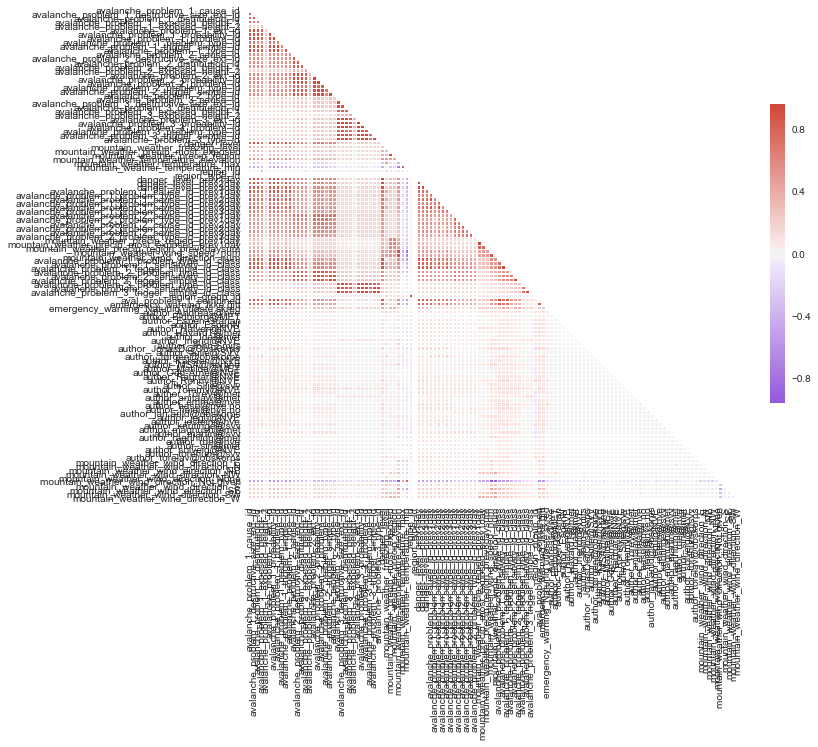

In [260]:
# Compute the correlation matrix - works only on numerical variables.
corr = varsom_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that some parameters are highly correlated. These are mainly the parameters belonging to the same avalanche problem. Depending on the ML algorithm we use we have to remove some of them.

In [261]:
#corr['avalanche_problem_1_cause_id'].sort_values(ascending=False)
#corr

In [262]:
#sns.pairplot(varsom_df.drop(['date_valid'], axis=1))

In [263]:
# Get all numerical features

num_feat = varsom_df._get_numeric_data().columns
num_feat

Index(['avalanche_problem_1_cause_id',
       'avalanche_problem_1_destructive_size_ext_id',
       'avalanche_problem_1_distribution_id',
       'avalanche_problem_1_exposed_height_1',
       'avalanche_problem_1_exposed_height_2', 'avalanche_problem_1_ext_id',
       'avalanche_problem_1_probability_id', 'avalanche_problem_1_problem_id',
       'avalanche_problem_1_problem_type_id',
       'avalanche_problem_1_trigger_simple_id',
       ...
       'mountain_weather_wind_direction_E',
       'mountain_weather_wind_direction_N',
       'mountain_weather_wind_direction_NE',
       'mountain_weather_wind_direction_NW',
       'mountain_weather_wind_direction_None',
       'mountain_weather_wind_direction_Not given',
       'mountain_weather_wind_direction_S',
       'mountain_weather_wind_direction_SE',
       'mountain_weather_wind_direction_SW',
       'mountain_weather_wind_direction_W'],
      dtype='object', length=122)

In [264]:
# let's see the details about remainig variables 

varsom_df.describe()

,avalanche_problem_1_cause_id,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_distribution_id,avalanche_problem_1_exposed_height_1,avalanche_problem_1_exposed_height_2,avalanche_problem_1_ext_id,avalanche_problem_1_probability_id,avalanche_problem_1_problem_id,avalanche_problem_1_problem_type_id,avalanche_problem_1_trigger_simple_id,...,mountain_weather_wind_direction_E,mountain_weather_wind_direction_N,mountain_weather_wind_direction_NE,mountain_weather_wind_direction_NW,mountain_weather_wind_direction_None,mountain_weather_wind_direction_Not given,mountain_weather_wind_direction_S,mountain_weather_wind_direction_SE,mountain_weather_wind_direction_SW,mountain_weather_wind_direction_W
count,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,...,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000,33264.000000
mean,7.504990,1.160955,1.012145,335.918711,34.704185,10.563672,1.642496,0.536195,7.453523,10.168951,...,0.027718,0.012205,0.013949,0.027898,0.004630,0.690536,0.034392,0.097042,0.051166,0.040464
std,7.876866,1.170598,1.026995,401.052501,150.560137,9.951452,1.561384,0.498696,10.807930,10.027306,...,0.164165,0.109803,0.117281,0.164683,0.067885,0.462280,0.182235,0.296019,0.220340,0.197048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,1.000000,1.000000,200.000000,0.000000,15.000000,3.000000,1.000000,5.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,13.000000,2.000000,2.000000,600.000000,0.000000,20.000000,3.000000,1.000000,10.000000,21.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,4.000000,4.000000,2100.000000,2000.000000,25.000000,5.000000,1.000000,50.000000,22.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Save data for further analysis

In [265]:
varsom_df.to_csv('varsom_ml_preproc_3y.csv', index_label='index')

#### Now we have clean data and can build a model

The library we'll use is called **sckit-learn**. 

http://scikit-learn.org

- Python library
- Access to well known machine learning algorithms
- Built on NumPy, SciPy, and matplotlib
- Open Source
- Well documented with many good tutorials


## Worklflow of scikit-learn

- Create model object
- .fit
- .predict
- evaluate